In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import integrate
from scipy import optimize
from scipy import stats
from scipy import interpolate
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
import quantecon as qecon

In [2]:
def get_labor(v, p, f):
    labor = (v['w']/(p['v']*v['k']**p['theta']*np.exp(v['eps'])))**(1/(p['v']-1))
    return labor

def get_production(v, p, f):
    prod_f = np.exp(v['eps'])*(v['k']**p['theta'])*(f['n'](v, p, f))**p['v']
    return prod_f

def get_objective(v, p, f):
    obj_1 = f['P'](v, p, f) - v['w']*f['n'](v, p, f)
    obj_2 = -(v['k_p'] - (1-p['delta'])*v['k'])
    obj_3 = - (p['phi']/2)*(v['k_p']/v['k'] - (1- p['delta']))**2 *v['k']
    
    obj = obj_1 + obj_2 + obj_3
    return obj

def get_tauchen(rho, sigma_u, m=3, n=7):
    """
    Function found on:
    https://quanteconpy.readthedocs.io/en/0.1.6/_modules/quantecon/tauchen.html

    """
    F = norm(loc=0, scale=sigma_u).cdf

    # standard deviation of y_t
    std_y = np.sqrt(sigma_u**2 / (1-rho**2))

    # top of discrete state space
    x_max = m * std_y

    # bottom of discrete state space
    x_min = - x_max

    # discretized state space
    x = np.linspace(x_min, x_max, n)

    step = (x_max - x_min) / (n - 1)
    half_step = 0.5 * step
    P = np.empty((n, n))

    for i in range(n):
        P[i, 0] = F(x[0]-rho * x[i] + half_step)
        P[i, n-1] = 1 - F(x[n-1] - rho * x[i] - half_step)
        for j in range(1, n-1):
            z = x[j] - rho * x[i]
            P[i, j] = F(z + half_step) - F(z - half_step)

    return x, P

In [52]:
def get_dictionaries():
    p = {'theta':0.21, 'v':0.64, 'delta':0.1, 'beta':0.96, \
         'phi':0.5, 'rho':0.9, 'sigma':0.02, 'n_eps':10}
    f = {'n':get_labor, 'P':get_production, 'obj':get_objective, 'tauchen':get_tauchen}
    
    shocks, transition = f['tauchen'](p['rho'], p['sigma'], n=p['n_eps'])
    mc = qecon.MarkovChain(transition)
    
    v = {'w':0.78297, 'c_f':0.01, 'k_min':.1, 'c_e':0.02, \
             'k_max':25, 'error':1, 'n':100, 'shocks':shocks, 'transition':transition, \
        'stationary_mc':  mc.stationary_distributions.reshape(1, p['n_eps']), \
        'm':1}
    return v, p, f

In [53]:
variables, params, functions = get_dictionaries()

In [54]:
def vfi(v, p, f, thres=1e-3):
    k_grid = np.linspace(v['k_min'], v['k_max'], v['n'])

    V1_old = np.zeros((p['n_eps'], v['n']))
    V1_new = np.zeros_like(V1_old)
    V1_temp = np.zeros_like(V1_new)
    V1 = np.zeros_like(V1_new)
    policy = np.zeros_like(V1_new)
    exit = np.zeros_like(V1_new)+0.5
    diff = np.ones_like(V1_old)
    
    comparison_matrix = ((1-p['delta'])*k_grid).reshape(1, v['n'])
    objective = np.zeros_like(V1_old)
    
    while thres < diff.max():
        v['k_p'] = k_grid.copy()

        for j in range(v['n']):
            v['k'] = k_grid[j]
            for i in range(p['n_eps']):
                v['eps'] = v['shocks'][i]
                objective[i,:] = f['obj'](v, p, f)
            
            V1 = objective + p['beta']*np.dot(v['transition'], V1_old)
            V1_temp[:, j] = V1.max(axis=1)
            policy[:, j] = k_grid[V1.argmax(axis=1)]
        

        V1_new = np.maximum(V1_temp-v['c_f'], comparison_matrix)
        diff = V1_new - V1_old
        diff = linalg.norm(diff)
        V1_old = V1_new.copy()
    
    policy[comparison_matrix >V1_temp-v['c_f']] = 0
    exit[comparison_matrix <V1_temp-v['c_f']] = 1
    exit[comparison_matrix >V1_temp-v['c_f']] = 0
    
    v_hat = (-k_grid +  p['beta']*np.dot(v['stationary_mc'],V1_new)).max()

    return V1_new, v_hat, policy, exit, k_grid

In [55]:
V1_new, v_hat, policy, exit, k_grid = vfi(variables, params, functions)

In [56]:
def equations_for_wage(w, v, p, f):
    v['w'] = w
    V1_new, v_hat = vfi(variables, params, functions)[0:2]
    print('Done')
    e = v['c_e'] - (v_hat*v['stationary_mc']).sum()
    return e

def solve_for_wage(v, p, f):
    F = lambda w: equations_for_wage(w, v, p, f)
    w_prime = optimize.root(F, 0.6).x
    return w_prime

In [57]:
variables['w'] = solve_for_wage(variables, params, functions)[0]

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


In [58]:
variables['w']

1.3485684659282107

In [59]:
V1_new, v_hat, policy, exit, k_grid = vfi(variables, params, functions)

<IPython.core.display.Javascript object>


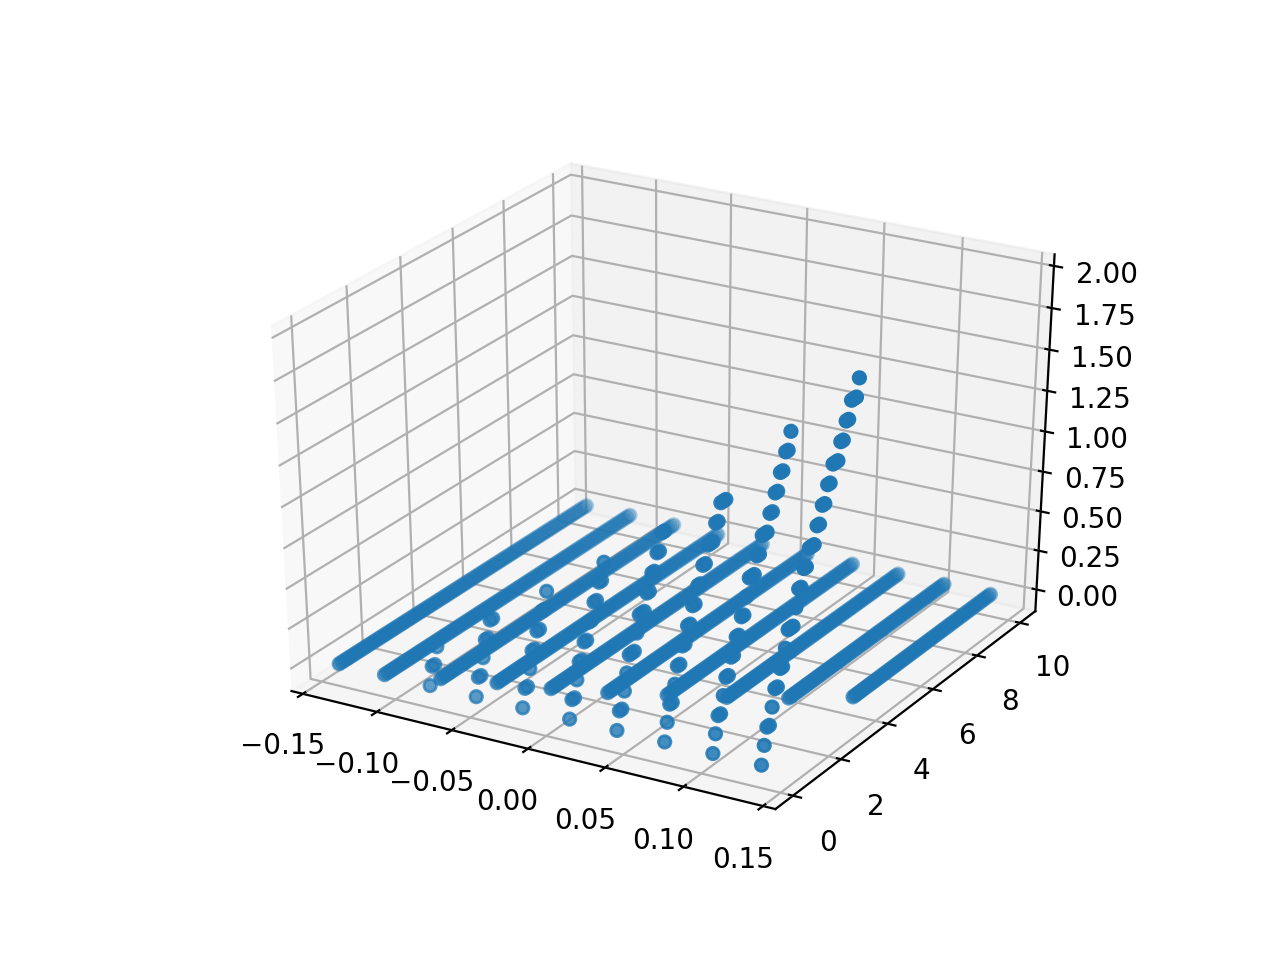

In [47]:
kk, SS = np.meshgrid(k_grid, variables['shocks'])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dem3d=ax.scatter(SS,kk, policy)

<IPython.core.display.Javascript object>


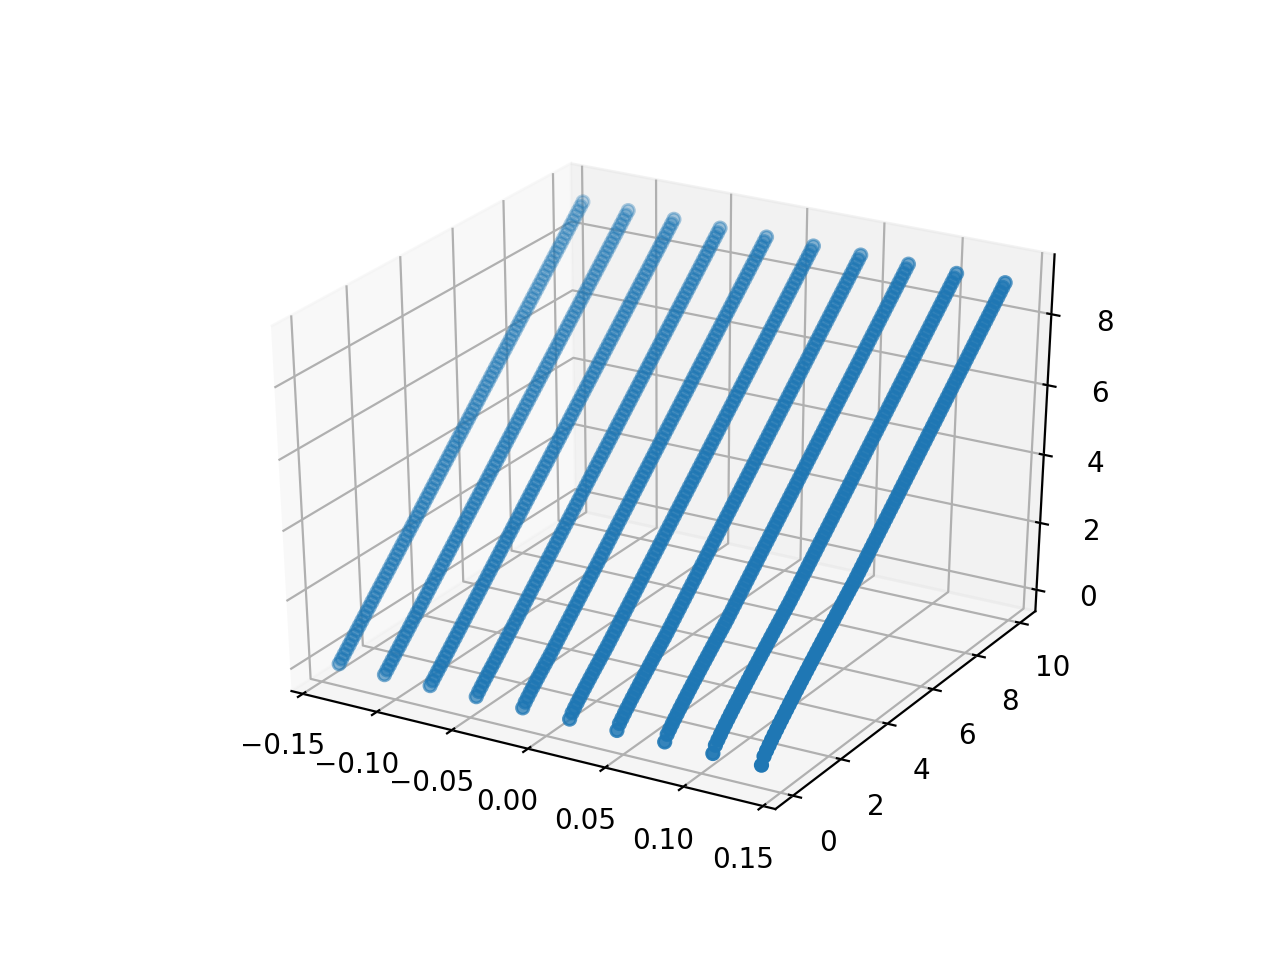

In [48]:
kk, SS = np.meshgrid(k_grid, variables['shocks'])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dem3d=ax.scatter(SS,kk, V1_new)

In [101]:

def get_g(v, p, f):
    V1_new, v_hat, policy, exit, k_grid = vfi(v, p, f)
    g_new = np.zeros_like(V1_new)
    g_old = np.zeros_like(V1_new)
    diff = 1

    while diff > 1e-5:
        for k in range(p['n_eps']):
            for l in range(v['n']):
                C = (policy == k_grid[l])
                
                transition = v['transition'].T
                curr_trans = transition[:, k]
        
                g_new[k,l] = np.sum(np.dot(curr_trans, exit*g_old*C)) + \
                v['m']*v['stationary_mc'][0,k]
        
        diff = linalg.norm(g_new-g_old)
        g_old = g_new.copy()
                
    return g_new

In [102]:
g_new = get_g(variables, params, functions)
g_new= g_new/g_new.sum()

<IPython.core.display.Javascript object>


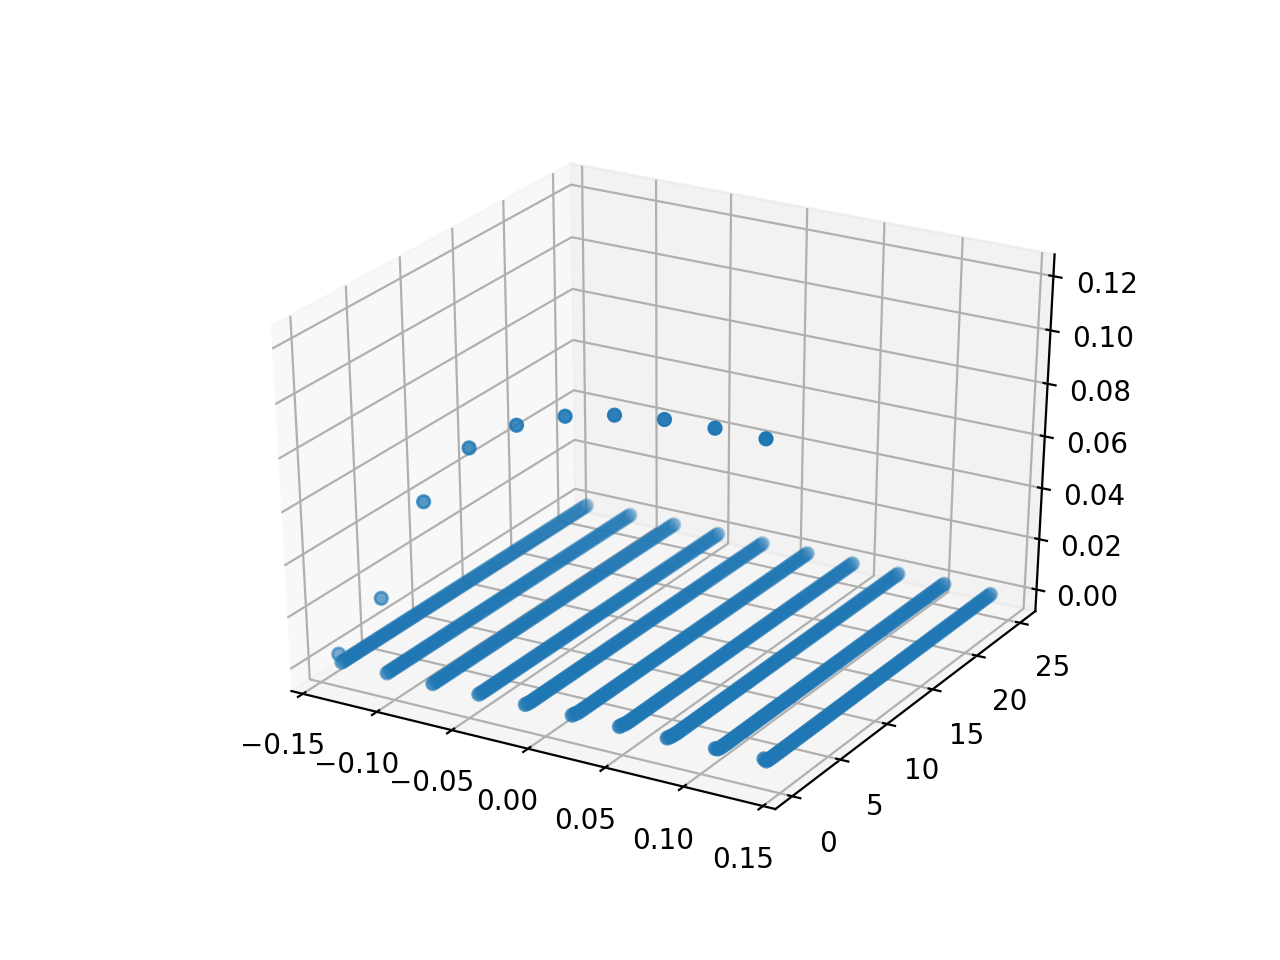

In [103]:
kk, SS = np.meshgrid(k_grid, variables['shocks'])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dem3d=ax.scatter(SS,kk, g_new)

In [121]:
curr_dim = params['n_eps']*variables['n']
T = np.zeros((curr_dim, curr_dim))
check = np.zeros((curr_dim, curr_dim))
for k in range(params['n_eps']):
    for l in range(variables['n']):
        for i in range(params['n_eps']):
            for j in range(variables['n']):
                C = (policy[i, j] == k_grid[l])
                #T[i*variables['n']+j, k*variables['n']+l] = (variables['transition'].T)[i, k] *C*exit[i, j]
                T[i*j, k*l] = (variables['transition'].T)[i, k] *C*exit[i, j]

In [122]:
def get_G_from_T(v, p, f):
    g_new = np.zeros_like(V1_new)
    g_old = np.zeros_like(V1_new)
    diff = 1

    while diff > 1e-5:
        for k in range(p['n_eps']):
            for l in range(v['n']):
                temp = np.zeros_like(g_new)
                for i in range(params['n_eps']):
                    for j in range(variables['n']):
                        temp[k, l] += T[i*j, k*l]*g_old[i, j]
                g_new[k, l] = temp[k,l] + v['m']*v['stationary_mc'][0, k]
        diff = linalg.norm(g_new-g_old)
        print(diff)
        g_old = g_new.copy()
                
    return g_new

In [123]:
g_new = get_G_from_T(variables, params, functions)

4.154635795050631
10.520696598157672
507.37533576004455
29305.06224769385
1694483.0745366246
97978627.72420359
5665332073.186133
327581514087.70715
18941457790133.066
1095235255288097.0
6.3328824936061464e+16
3.6618069482498913e+18
2.117334427062099e+20


KeyboardInterrupt: 

In [ ]:
g_new.shape

In [ ]:
kk, SS = np.meshgrid(k_grid, variables['shocks'])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dem3d=ax.scatter(SS,kk, g_new)

In [99]:
g_new.sum()

100.0